In [4]:
import pandas as pd
import collections
import random
import scipy.stats
import numpy as np
import itertools
import re

import seaborn as sns
sns.set_style("whitegrid")


In [5]:
import historical.util as util
import historical.ioutils as ioutils

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [7,4]

In [7]:
%%script false --no-raise-error

#We need to initialize util
import argparse
parse = argparse.ArgumentParser()
util.add_arguments(parse)
#--use-sample for faster, lower memory tests, although things are pretty fast as-is
#args = parse.parse_args(args=["--use-sample"])
args = parse.parse_args(args=[])
util.process_arguments(args)

In [8]:
%%script false --no-raise-error

#Initialize the database
ioutils.__init_db()

In [9]:
#Load the data
import pickle
#with open("../data/policy_text_v11.pickle", "rb") as f:
with open("../data/deduped_policy_text_v11.pickle", "rb") as f:
    df = pickle.load(f)
    

# Find hits

In [10]:
%%script false --no-raise-error

#Get all elements in the data set
all_doms = set()
all_ys = set()
hits = []

for dom, y, s in ioutils.policies_db.execute("SELECT site_url,year,season FROM policy_texts"):
    all_doms.add(dom)
    ys = "%d%s" % (y,s)
    all_ys.add(ys)
    hits.append((dom,ys))

all_ys = sorted(list(all_ys))
all_doms = list(all_doms)

In [11]:
#Get all elements in the data set
all_doms = set()
all_ys = set()
hits = []

for i, row in df.iterrows():
    dom = row.site_url
    y = row.year
    s = row.season
    all_doms.add(dom)
    ys = "%d%s" % (y,s)
    all_ys.add(ys)
    hits.append((dom,ys))

all_ys = sorted(list(all_ys))
all_doms = list(all_doms)

In [12]:
#Compute coverage based on number of total slots
full_coverage = len(all_doms) * len(all_ys)
real_coverage = len(hits)
"Coverage over all intervals %s%%" % (real_coverage/full_coverage * 100)

'Coverage over all intervals 18.24392691257022%'

In [13]:
hits_dict = {dom:{ys:False for ys in all_ys} for dom in all_doms}
for dom,ys in hits:
    hits_dict[dom][ys]=True
df = pd.DataFrame.from_dict(hits_dict,orient="index")

# Find gaps

What are gaps? Generally, gaps are any domain-interval (d,i) which we do not have a policy for, but we do have a policy for (d,i') where i!=i'

We describe a "hit" as an i for which we have a policy for (d,i) 

We define 3 types of gaps.

- Pre-gaps: gaps which occur in an interval before all hits.
- Post-gaps: gaps which occur in an interval after all hits.
- Internal-gaps: gaps which occur between two hits (i.e. gaps which are not pre-gaps or post-gaps)


In [14]:
def get_gaps(all_doms,all_ys):
    possible_gaps = 0
    actual_gaps = 0
    gaps = []
    pre_missing = []
    post_missing = []
    have_gaps = []
    dont_have_gaps = []
    
    gap_cts = []
    widths = []
    gapped_widths = []
    
    for dom in all_doms:
        #Missing -> list of domain-intervals missing from dataset
        #gap_ct -> Running count of *gaps*
        #Hits -> Number of total hits
        missing = None
        gap_ct = 0
        hits = 0
        for ys in all_ys:
            if hits_dict[dom][ys]:
                #Not missing
                if missing is not None:
                    #If we've had a hit before, convert missing values
                    #Into gaps
                    gaps += missing
                    gap_ct += len(missing)
                hits += 1 #Count hits
                missing = [] #Reset missing
            else:
                #Missing
                if missing is not None:
                    #We've seen a hit, so record this as a possible gap
                    missing.append((dom,ys))
                else:
                    #We have not seen a hit, record this as missing but not a gap
                    pre_missing.append((dom,ys))
                    
        #Record things after the last hit as missing but not a gap
        post_missing += missing
        
        #Record number of observed gaps
        actual_gaps += gap_ct
        
        #First & last true cannot be a gap
        possible_gaps += max(0,gap_ct + hits - 2)
        
        #Record if we saw gaps or not for this domain
        if gap_ct > 0:
            have_gaps.append(dom)
            gap_cts.append(gap_ct)
            gapped_widths.append(gap_ct + hits)
        else:
            dont_have_gaps.append(dom)
            
        widths.append(gap_ct + hits)
            
    d = {
        "actual_gaps": actual_gaps,
        "possible_gaps": possible_gaps,
        "gaps": gaps,
        "pre_missing": pre_missing,
        "post_missing": post_missing,
        "have_gaps": have_gaps,
        "dont_have_gaps": dont_have_gaps,
        "gap_cts": gap_cts,
        "widths": widths,
        "gapped_widths": gapped_widths,
    }
        
    return d

In [15]:
d=get_gaps(all_doms,all_ys)

actual = d["actual_gaps"]
possible = d["possible_gaps"]
gaps = d["gaps"]
pre_gaps = d["pre_missing"]
post_gaps = d["post_missing"]
have_gaps = d["have_gaps"]
dont_have_gaps = d["dont_have_gaps"]
gap_cts = d["gap_cts"]
widths = d["widths"]
gapped_widths = d["gapped_widths"]

print("Gaps perc: %f,actual=%s,possible=%s" % (actual/possible*100,actual,possible))
print("Domins w/ gaps perc: %f" % (len(have_gaps) / (len(have_gaps) + len(dont_have_gaps)) * 100))

print("Of domains that have gaps, averge num gaps: %s, median gaps: %s" % (np.mean(gap_cts),np.median(gap_cts)))

print("Lifespan average: %s intervals, median: %s intervals" % (np.mean(widths),np.median(widths)))
print("Of domains with gaps, lifespan average: %s intervals, median: %s intervals" % (np.mean(gapped_widths),np.median(gapped_widths)))

Gaps perc: 29.849744,actual=301903,possible=1011409
Domins w/ gaps perc: 54.091743
Of domains that have gaps, averge num gaps: 5.144115592359727, median gaps: 3.0
Lifespan average: 11.17474815436087 intervals, median: 9.0 intervals
Of domains with gaps, lifespan average: 16.502206546371553 intervals, median: 15.0 intervals


In [16]:
print("Pre Gaps perc of all gaps: %f" % (len(pre_gaps)/(len(gaps)+len(post_gaps)+len(pre_gaps))*100))
print("Mid Gaps perc of all gaps: %f" % (len(gaps)/(len(gaps)+len(post_gaps)+len(pre_gaps))*100))
print("Post Gaps perc of all gaps: %f" % (len(post_gaps)/(len(gaps)+len(post_gaps)+len(pre_gaps))*100))
print("All gaps perc of possible: %f" % ((len(gaps)+len(post_gaps)+len(pre_gaps)) / (len(all_doms) * len(all_ys)) * 100))

Pre Gaps perc of all gaps: 76.525534
Mid Gaps perc of all gaps: 7.398843
Post Gaps perc of all gaps: 16.075623
All gaps perc of possible: 81.756073


# Working with Alexa rank

In [17]:
import historical.alexa as alexa
alexa.load()

In [18]:
all_alexa_ys = list(util.iter_yearseason())

In [19]:
def missing_perc(ranks, default_rank):
    num_missing = sum((1 for rank in ranks if rank == default_rank),0)
    total = len(ranks)
    return num_missing/total * 100, num_missing, total

def smooth_graph(x,y,label=None):
    df = pd.DataFrame(list(zip(x,y)), columns=["Rank","Absent"]).sort_values(by=['Rank'])
    df['Absent_SMA'] = df["Absent"].rolling(window=10000).mean()
    sample = df.sample(n=100000, weights=(df.Rank.apply(lambda r: np.log(1000001) - np.log(r) + 1)))
    sns.lineplot(x="Rank", y="Absent_SMA", data=sample,label=label)
    plt.ylim(0,1)
    plt.xscale("log")

def do_table(x,y,label=None):
    df = pd.DataFrame(list(zip(x,y)), columns=["Rank","Absent"]).sort_values(by=['Rank'])
    for thresh in [1,10,100,1000,10000,100000,1000000]:
        absent = len(df[(df.Rank<=thresh) & (df.Absent == 1)])
        present = len(df[(df.Rank<=thresh) & (df.Absent == 0)])
        print(thresh,absent/(absent+present),present,absent)
    df['Absent_SMA'] = df["Absent"].rolling(window=10000).mean()
    print(df)
    return df

    
def bin_graph(x,y,label=None):
    df = pd.DataFrame(list(zip(x,y)), columns=["Rank","Absent"]).sort_values(by=['Rank'])
    df['Absent_SMA'] = df["Absent"].rolling(window=10000).mean()
    sample = df.sample(n=100000, weights=(df.Rank.apply(lambda r: np.log(1000001) - np.log(r) + 1)))
    sns.barplot(x="Rank", y="Absent_SMA", data=sample,label=label)
    plt.ylim(0,1)
    plt.xscale("log")

#Default rank is 1m + 1 -> Assume it comes after all other Alexa items if we can't find it
def correlate_rank(hits, missing, default_rank = 1000001, alexa_only=False, ranked=False, log_rank=True, pearson=True,label=None):    
    hit_ranks = [alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) for dom,ys in hits]
    missing_ranks = [alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) for dom,ys in missing]
    

    if ranked:
        hit_ranks = [1 for rank in hit_ranks if rank != default_rank] + \
                    [0 for rank in hit_ranks if rank == default_rank]
        missing_ranks = [1 for rank in missing_ranks if rank != default_rank] + \
                        [0 for rank in missing_ranks if rank == default_rank]
    elif alexa_only:
        hit_ranks = list(filter(lambda rank: rank != default_rank, hit_ranks))
        missing_ranks = list(filter(lambda rank: rank != default_rank, missing_ranks))
    else:
        print("Hits: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(hit_ranks,default_rank))
        print("Gaps: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(missing_ranks,default_rank))
    
    reg_ranks = hit_ranks+missing_ranks
    #0 if hit, 1 if gap
    bool_vals = [0]*len(hit_ranks) + [1]*len(missing_ranks)
    
    
    if log_rank and not ranked:
        ranks = list(np.log(reg_ranks))
    else:
        ranks = reg_ranks
    
    if pearson:
        corr = scipy.stats.pearsonr(ranks,bool_vals)
    else:
        corr = scipy.stats.spearmanr(ranks,bool_vals)
    hit_mean = np.mean(hit_ranks)
    missing_mean = np.mean(missing_ranks)
    hit_median = np.median(hit_ranks)
    missing_median = np.median(missing_ranks)
    print("Corr: %s\nHit mean rank: %f\nHit median rank: %f\nMissing mean rank: %f\nMissing median rank: %f" % (corr,hit_mean,hit_median,missing_mean,missing_median))
    
    try:
        smooth_graph(reg_ranks, bool_vals,label=label)
        return do_table(reg_ranks, bool_vals,label=label)
    except ValueError:
        pass

In [20]:
hit_ranks = [x for x in [((dom,ys),alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=-1)) for dom,ys in hits] if x[1] != -1]
all_gap_ranks = [x for x in [((dom,ys),alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=-1)) for dom,ys in gaps+pre_gaps+post_gaps] if x[1] != -1]

In [21]:
rows = [x for x in [(dom,ys,alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=-1),False) for dom,ys in hits] if x[2] != -1] + [x for x in [(dom,ys,alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=-1),True) for dom,ys in gaps+pre_gaps+post_gaps] if x[2] != -1]

df=pd.DataFrame(rows,
             columns=("Site", "Interval", "Rank", "Absent"))

In [22]:
df[(df.Absent == True) & (df.Rank <= 100)].sample(10)

,Site,Interval,Rank,Absent
737225,http://stackoverflow.com,2018A,63,True
1234236,http://msn.com,2016B,33,True
785339,http://mediafire.com,2009B,66,True
820193,http://imdb.com,2018A,52,True
677637,http://t.co,2017A,32,True
1290246,http://pornhub.com,2012B,68,True
794536,http://aol.com,2013A,67,True
785341,http://mediafire.com,2010B,63,True
1253945,http://google.co.in,2016B,7,True
667844,http://ask.com,2014B,35,True


In [23]:
def compare_ratio(thresh=1000):
    low_rank_hits = list(filter(lambda x: x[1] <= thresh, hit_ranks))
    low_rank_gaps = list(filter(lambda x: x[1] <= thresh, all_gap_ranks))
    print(thresh,1-len(low_rank_hits)/(len(low_rank_gaps)+len(low_rank_hits)),len(low_rank_hits),len(low_rank_gaps))

In [24]:
compare_ratio(5)
compare_ratio(10)
compare_ratio(100)
compare_ratio(1000)
compare_ratio(10000)
compare_ratio(100000)
compare_ratio(1000000)
compare_ratio(100000000)

5 0.8444444444444444 14 76
10 0.7972972972972973 30 118
100 0.6555863342566943 373 710
1000 0.5147286821705426 5008 5312
10000 0.4800435199091758 43967 40592
100000 0.48650095516994696 322291 305346
1000000 0.5099889736321008 642157 668338
100000000 0.5099889736321008 642157 668338


## Scoring gaps for Alexa ranking

Hits vs Gaps:
Hits: missing rank for 29.48%, missing: 268389, total: 910546
Gaps: missing rank for 36.55%, missing: 110344, total: 301903
Corr: (0.03358650725616886, 1.4880306363662194e-299)
Hit mean rank: 416499.139663
Hit median rank: 187446.000000
Missing mean rank: 471657.674183
Missing median rank: 241237.000000
1 0.6428571428571429 5 9
10 0.6296296296296297 30 51
100 0.44822485207100593 373 303
1000 0.3065632788701191 5008 2214
10000 0.2612574769809799 43967 15549
100000 0.23281218013111352 322291 97803
1000000 0.22976529177801552 642157 191559
            Rank  Absent  Absent_SMA
986404         1       1         NaN
16596          1       0         NaN
1062505        1       1         NaN
986397         1       1         NaN
986398         1       1         NaN
...          ...     ...         ...
635804   1000001       0         0.0
635803   1000001       0         0.0
635802   1000001       0         0.0
635816   1000001       0         0.0
606224   1000001       0         0.0

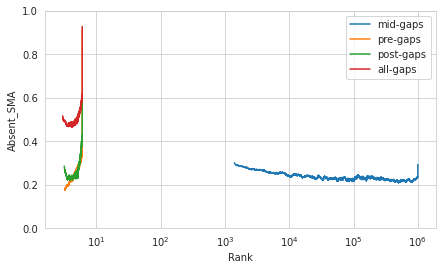

In [25]:
print("Hits vs Gaps:")
correlate_rank(hits,gaps,label="mid-gaps")
print("\nHits vs Pre-Gaps:")
correlate_rank(hits,pre_gaps,label="pre-gaps")
print("\nHits vs Post-Gaps:")
correlate_rank(hits,post_gaps,label="post-gaps")
print("\nHits vs All Gaps:")
correlate_rank(hits,gaps+pre_gaps+post_gaps,label="all-gaps")

plt.legend()

## Scoring gaps with Alexa ranking, keeping only those domain-intervals in the top 1m

Hits vs Gaps:
Corr: (-0.02259199500054731, 1.4489148714850206e-94)
Hit mean rank: 172625.007958
Hit median rank: 99565.000000
Missing mean rank: 167315.325644
Missing median rank: 97406.000000


KeyboardInterrupt: 

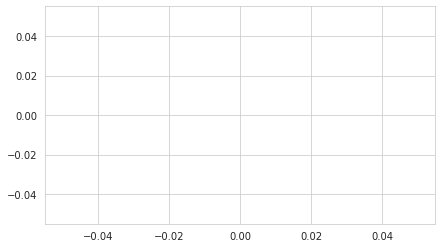

In [26]:
print("Hits vs Gaps:")
correlate_rank(hits,gaps,alexa_only=True,label="mid-gaps")
print("\nHits vs Pre-Gaps:")
correlate_rank(hits,pre_gaps,alexa_only=True,label="pre-gaps")
print("\nHits vs Post-Gaps:")
correlate_rank(hits,post_gaps,alexa_only=True,label="post-gaps")
print("\nHits vs All Gaps:")
df = correlate_rank(hits,gaps+pre_gaps+post_gaps,label="all-gaps",alexa_only=True)

plt.ylabel("Gap Proportion")
plt.savefig("figures/gap_rank_absent.pdf",bbox_inches='tight')

## Scoring gaps with presence in Alexa ranking as the score, not the ranking itself

In [ ]:
print("Hits vs Gaps:")
correlate_rank(hits,gaps,ranked=True)
print("\nHits vs Pre-Gaps:")
correlate_rank(hits,pre_gaps,ranked=True)
print("\nHits vs Post-Gaps:")
correlate_rank(hits,post_gaps,ranked=True)

## Missing rank perc

In [27]:
def missing_rank_perc(all_ss, missing, default_rank = 1000001, alexa_only=False, ranked=False, log_rank=True, pearson=True,label=None):    
    hit_ranks = [(dom,ys) for dom,ys in all_ss if alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) == default_rank]
    missing_ranks = [(dom,ys) for dom,ys in missing if alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) == default_rank]
    
    print(len(missing_ranks)/(len(hit_ranks)))

In [28]:
all_ss = hits+gaps+pre_gaps+post_gaps

print("Hits vs Gaps:")
missing_rank_perc(all_ss,gaps,alexa_only=True,label="mid-gaps")
print("\nHits vs Pre-Gaps:")
missing_rank_perc(all_ss,pre_gaps,alexa_only=True,label="pre-gaps")
print("\nHits vs Post-Gaps:")
missing_rank_perc(all_ss,post_gaps,alexa_only=True,label="post-gaps")
print("\nHits vs All Gaps:")
missing_rank_perc(all_ss,gaps+pre_gaps+post_gaps,label="all-gaps",alexa_only=True)

Hits vs Gaps:
0.029981043125327574

Hits vs Pre-Gaps:
0.7844214539545203

Hits vs Post-Gaps:
0.1126748049631853

Hits vs All Gaps:
0.9270773020430332


## Plotting rank vs gap

In [29]:
default_rank=1000001
hit_ranks = [alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) for dom,ys in hits]
gap_ranks = [alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) for dom,ys in gaps]
ranks = hit_ranks + gap_ranks
gap_bool = [0] * len(hit_ranks) + [1] * len(gap_ranks)

ranks_sorted, gap_bool_sorted = zip(*sorted(zip(ranks,gap_bool)))

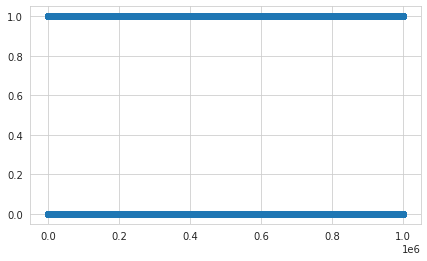

In [30]:
plt.plot(ranks_sorted, gap_bool_sorted, 'o')

In [31]:
default_rank = 1000001
hit_ranks = [(dom,ys,alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank)) for dom,ys in hits]

In [32]:
hit_ranks_f = list(filter(lambda t: t[2] == default_rank, hit_ranks))
hit_ranks_f[random.randrange(len(hit_ranks_f))]

('http://pricescan.com', '2003A', 1000001)

# Trying things with year long intervals now!

In [33]:
def get_gaps_by_year(all_doms,all_y):
    
    possible_gaps = 0
    actual_gaps = 0
    gaps = []
    pre_missing = []
    post_missing = []
    have_gaps = []
    dont_have_gaps = []
    
    gap_cts = []
    
    for dom in all_doms:
        #Missing -> list of domain-intervals missing from dataset
        #gap_ct -> Running count of *gaps*
        #Hits -> Number of total hits
        missing = None
        gap_ct = 0
        hits = 0
        for y in all_y:
            if hits_dict_y[dom][y]:
                #Not missing
                if missing is not None:
                    #If we've had a hit before, convert missing values
                    #Into gaps
                    gaps += missing
                    gap_ct += len(missing)
                hits += 1 #Count hits
                missing = [] #Reset missing
            else:
                #Missing
                if missing is not None:
                    #We've seen a hit, so record this as a possible gap
                    missing.append((dom,y))
                else:
                    #We have not seen a hit, record this as missing but not a gap
                    pre_missing.append((dom,y))
                    
        #Record things after the last hit as missing but not a gap
        post_missing += missing
        
        #Record number of observed gaps
        actual_gaps += gap_ct
        
        #First & last true cannot be a gap
        possible_gaps += max(0,gap_ct + hits - 2)
        
        #Record if we saw gaps or not for this domain
        if gap_ct > 0:
            have_gaps.append(dom)
            gap_cts.append(gap_ct)
        else:
            dont_have_gaps.append(dom)
            
    d = {
        "actual_gaps": actual_gaps,
        "possible_gaps": possible_gaps,
        "gaps": gaps,
        "pre_missing": pre_missing,
        "post_missing": post_missing,
        "have_gaps": have_gaps,
        "dont_have_gaps": dont_have_gaps,
        "gap_cts": gap_cts,
    }
        
    return d

In [34]:
def get_alexa_ranks_y(hits):
    return [
            max(alexa.get_alexa_rank(int(y), "A", dom, default_rank=default_rank),
                alexa.get_alexa_rank(int(y), "B", dom, default_rank=default_rank)
               )for dom,ys in hits
           ]

#Default rank is 1m + 1 -> Assume it comes after all other Alexa items if we can't find it
def correlate_rank_y(hits, missing, default_rank = 1000001, alexa_only=False, ranked=False):
    hit_ranks = get_alexa_ranks_y(hits)
    missing_ranks = get_alexa_ranks_y(missing)

    if ranked:
        hit_ranks = [1 for rank in hit_ranks if rank != default_rank] + \
                    [0 for rank in hit_ranks if rank == default_rank]
        missing_ranks = [1 for rank in missing_ranks if rank != default_rank] + \
                        [0 for rank in missing_ranks if rank == default_rank]
    elif alexa_only:
        hit_ranks = list(filter(lambda rank: rank != default_rank, hit_ranks))
        missing_ranks = list(filter(lambda rank: rank != default_rank, missing_ranks))
    else:    
        print("Hits: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(hit_ranks,default_rank))
        print("Gaps: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(missing_ranks,default_rank))
    
    ranks = hit_ranks+missing_ranks
    #0 if hit, 1 if gap
    bool_vals = [0]*len(hit_ranks) + [1]*len(missing_ranks)
    corr = scipy.stats.spearmanr(ranks,bool_vals)
    hit_mean = np.mean(hit_ranks)
    missing_mean = np.mean(missing_ranks)
    hit_median = np.median(hit_ranks)
    missing_median = np.median(missing_ranks)
    print("Corr: %s\nHit mean rank: %f\nHit median rank: %f\nMissing mean rank: %f\nMissing median rank: %f" % (corr,hit_mean,hit_median,missing_mean,missing_median))

In [35]:
#Get all of the years, not intervals!
all_y = []
for ys in all_ys:
    y = ys[:4]
    #We could do this with sets not lists but... meh
    if y in all_y:
        continue
    all_y.append(y)

In [36]:
#We need to consolidate hits to once per year to not overrepresent hits
hits_y = set(itertools.starmap(lambda dom,ys: (dom,ys[:4]), hits))

hits_dict_y = {dom:{y:((dom,y) in hits_y) for y in all_y} for dom in all_doms}
    
hits_y = list(hits_y)

In [37]:
d_y=get_gaps_by_year(all_doms,all_y)

actual_y = d_y["actual_gaps"]
possible_y = d_y["possible_gaps"]
gaps_y = d_y["gaps"]
pre_gaps_y = d_y["pre_missing"]
post_gaps_y = d_y["post_missing"]
have_gaps_y = d_y["have_gaps"]
dont_have_gaps_y = d_y["dont_have_gaps"]
gap_cts_y = d_y["gap_cts"]

print("Gaps perc: %f,actual=%s,possible=%s" % (actual_y/possible_y*100,actual_y,possible_y))
print("Domins w/ gaps perc: %f" % (len(have_gaps_y) / (len(have_gaps_y) + len(dont_have_gaps_y)) * 100))

print("Of domains that have gaps, averge num gaps: %s, median gaps: %s" % (np.mean(gap_cts_y),np.median(gap_cts_y)))

Gaps perc: 20.427963,actual=94139,possible=460834
Domins w/ gaps perc: 29.464788
Of domains that have gaps, averge num gaps: 2.944696424661391, median gaps: 2.0


## Scoring gaps for Alexa ranking

In [38]:
print("Hits vs Gaps:")
correlate_rank_y(hits_y,gaps_y)
print("\nHits vs Pre-Gaps:")
correlate_rank_y(hits_y,pre_gaps_y)
print("\nHits vs Post-Gaps:")
correlate_rank_y(hits_y,post_gaps_y)


Hits vs Gaps:
Hits: missing rank for 58.35%, missing: 328693, total: 563304
Gaps: missing rank for 51.32%, missing: 48312, total: 94139
Corr: SpearmanrResult(correlation=-0.05373938371285297, pvalue=0.0)
Hit mean rank: 661223.839891
Hit median rank: 1000001.000000
Missing mean rank: 597285.990344
Missing median rank: 1000001.000000

Hits vs Pre-Gaps:
Hits: missing rank for 58.35%, missing: 328693, total: 563304
Gaps: missing rank for 64.37%, missing: 987957, total: 1534770
Corr: SpearmanrResult(correlation=0.059411019654638623, pvalue=0.0)
Hit mean rank: 661223.839891
Hit median rank: 1000001.000000
Missing mean rank: 713987.591834
Missing median rank: 1000001.000000

Hits vs Post-Gaps:
Hits: missing rank for 58.35%, missing: 328693, total: 563304
Gaps: missing rank for 82.01%, missing: 248695, total: 303264
Corr: SpearmanrResult(correlation=0.23773912925651372, pvalue=0.0)
Hit mean rank: 661223.839891
Hit median rank: 1000001.000000
Missing mean rank: 858636.068937
Missing median rank

## Scoring gaps with Alexa ranking, keeping only those domain-intervals in the top 1m

In [39]:
print("Hits vs Gaps:")
correlate_rank_y(hits_y,gaps_y,alexa_only=True)
print("\nHits vs Pre-Gaps:")
correlate_rank_y(hits_y,pre_gaps_y,alexa_only=True)
print("\nHits vs Post-Gaps:")
correlate_rank_y(hits_y,post_gaps_y,alexa_only=True)

Hits vs Gaps:
Corr: SpearmanrResult(correlation=-0.02994913320142535, pvalue=1.1344976523571081e-56)
Hit mean rank: 186592.722477
Hit median rank: 128043.000000
Missing mean rank: 172733.487529
Missing median rank: 114829.000000

Hits vs Pre-Gaps:
Corr: SpearmanrResult(correlation=0.037179743358436275, pvalue=4.6045183388778165e-237)
Hit mean rank: 186592.722477
Hit median rank: 128043.000000
Missing mean rank: 197231.500279
Missing median rank: 138061.000000

Hits vs Post-Gaps:
Corr: SpearmanrResult(correlation=0.04470586523491346, pvalue=7.821010159383358e-128)
Hit mean rank: 186592.722477
Hit median rank: 128043.000000
Missing mean rank: 214373.730781
Missing median rank: 146743.000000


## Scoring gaps with presence in Alexa ranking as the score, not the ranking itself

In [40]:
print("Hits vs Gaps:")
correlate_rank_y(hits_y,gaps_y,ranked=True)
print("\nHits vs Pre-Gaps:")
correlate_rank_y(hits_y,pre_gaps_y,ranked=True)
print("\nHits vs Post-Gaps:")
correlate_rank_y(hits_y,post_gaps_y,ranked=True)

Hits vs Gaps:
Corr: SpearmanrResult(correlation=0.0497948576818668, pvalue=0.0)
Hit mean rank: 0.416491
Hit median rank: 0.000000
Missing mean rank: 0.486801
Missing median rank: 0.000000

Hits vs Pre-Gaps:
Corr: SpearmanrResult(correlation=-0.055190660803549826, pvalue=0.0)
Hit mean rank: 0.416491
Hit median rank: 0.000000
Missing mean rank: 0.356283
Missing median rank: 0.000000

Hits vs Post-Gaps:
Corr: SpearmanrResult(correlation=-0.23927120874413174, pvalue=0.0)
Hit mean rank: 0.416491
Hit median rank: 0.000000
Missing mean rank: 0.179939
Missing median rank: 0.000000


# Missing vs Not missing domains

In [41]:
possible_doms = set()
#Iter years
for season_dict in alexa.alexa_rankings.values():
    #iter seasons
    for dom_dict in season_dict.values():
        #iter domains
        for dom, ranking in dom_dict.items():
            if ranking <= 100000:
                possible_doms.add("http://%s" % dom)
len(possible_doms)

541616

In [42]:
extra_doms = set(all_doms) - possible_doms
print(len(extra_doms))
print("\n".join(extra_doms))

0



In [43]:
missing_doms = possible_doms - set(all_doms)
len(missing_doms),len(missing_doms)/len(possible_doms)

(433117, 0.7996754157927388)

In [44]:
print(len(missing_doms) / len(possible_doms) * 100)

79.96754157927388


In [45]:
#We want to correlate the best ranking
def correlate_domain_ranks(hits, missing, default_rank = 1000001, alexa_only=False, ranked=False):
    hit_ranks = [
        (min(alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank)
        for ys in all_alexa_ys)) for dom in hits
    ]
    missing_ranks = [
        (min(alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank)
        for ys in all_alexa_ys)) for dom in missing
    ]
    if ranked:
        hit_ranks = [1 for rank in hit_ranks if rank != default_rank] + \
                    [0 for rank in hit_ranks if rank == default_rank]
        missing_ranks = [1 for rank in missing_ranks if rank != default_rank] + \
                        [0 for rank in missing_ranks if rank == default_rank]
    elif alexa_only:
        hit_ranks = list(filter(lambda rank: rank != default_rank, hit_ranks))
        missing_ranks = list(filter(lambda rank: rank != default_rank, missing_ranks))
    else:    
        print("Hits: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(hit_ranks,default_rank))
        print("Gaps: missing rank for %0.2f%%, missing: %d, total: %d" % missing_perc(missing_ranks,default_rank))
    
    ranks = hit_ranks+missing_ranks
    #0 if hit, 1 if gap
    bool_vals = [0]*len(hit_ranks) + [1]*len(missing_ranks)
    corr = scipy.stats.spearmanr(ranks,bool_vals)
    hit_mean = np.mean(hit_ranks)
    missing_mean = np.mean(missing_ranks)
    hit_median = np.median(hit_ranks)
    missing_median = np.median(missing_ranks)
    print("Corr: %s\nHit mean rank: %f\nHit median rank: %f\nMissing mean rank: %f\nMissing median rank: %f" % (corr,hit_mean,hit_median,missing_mean,missing_median))

In [46]:
correlate_domain_ranks(all_doms,missing_doms)

Hits: missing rank for 0.00%, missing: 0, total: 108499
Gaps: missing rank for 0.00%, missing: 0, total: 433117
Corr: SpearmanrResult(correlation=0.06971460797701604, pvalue=0.0)
Hit mean rank: 48613.526945
Hit median rank: 48013.000000
Missing mean rank: 53660.307956
Missing median rank: 54902.000000


In [47]:
correlate_domain_ranks(all_doms,missing_doms)

Hits: missing rank for 0.00%, missing: 0, total: 108499
Gaps: missing rank for 0.00%, missing: 0, total: 433117
Corr: SpearmanrResult(correlation=0.06971460797701604, pvalue=0.0)
Hit mean rank: 48613.526945
Hit median rank: 48013.000000
Missing mean rank: 53660.307956
Missing median rank: 54902.000000


In [48]:
def cumulative_function(ranks):
    xs = [0]
    ys = [0]
    for r in ranks:
        if r != xs[-1]:
            xs.append(r)
            ys.append(ys[-1]+1)
        else:
            ys[-1] += 1
    return xs, list(map(lambda y: y / len(ranks), ys))

In [49]:
present_ranks = sorted([
    (min(alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank)
    for ys in all_alexa_ys)) for dom in all_doms
])
missing_ranks = sorted([
    (min(alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank)
    for ys in all_alexa_ys)) for dom in missing_doms
])


In [50]:
present_coords = cumulative_function(present_ranks)
missing_coords = cumulative_function(missing_ranks)

In [51]:
print(present_coords[0][-1],present_coords[1][-1],len(all_doms),len(present_ranks))
print(missing_coords[0][-1],missing_coords[1][-1],len(missing_doms),len(missing_ranks))

100000 1.0 108499 108499
100000 1.0 433117 433117


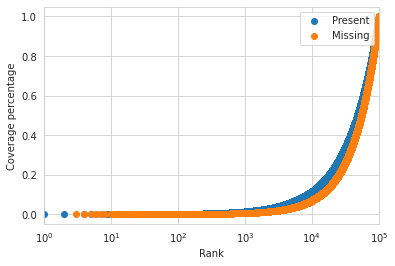

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

plt.scatter(*present_coords,label="Present")
plt.scatter(*missing_coords,label="Missing")
plt.legend()

plt.xscale("log")
plt.xlim(1,100000)

plt.xlabel("Rank")

plt.ylabel("Coverage percentage")


#Also plot with real domain union

pass

# Head/Tail dip hypothesis testing
We believe that the bell-curve-like shape of the privacy policies we collect may be due to an overrepresentation of the middle domains.

Here we test hypothesis under the assumption that domains are archived if they're in the top 1m

In [53]:
def count_for_ys(ys):
    default_rank = 1000001
    vals_in_alexa = (1 for dom in possible_doms
                     if alexa.get_alexa_rank(int(ys[:4]), ys[4], dom, default_rank=default_rank) != default_rank)
    return sum(vals_in_alexa, 0)

In [54]:
counts = list(map(count_for_ys, all_alexa_ys))
print(",".join(("%d" % c for c in counts)))

171896,186436,198825,210855,219863,224750,230284,234919,241248,238985,239138,239034,241120,243953,244353,248068,246926,246023,208763,207441,203155,162288


In [60]:
actual_counts = list(df[df.Interval>="2009A"].groupby(["Interval"]).size())

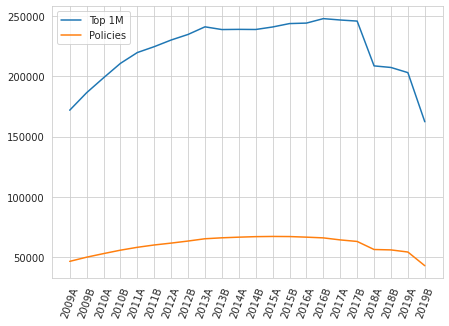

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 5) # (w, h)

fig,ax = plt.subplots()
plt.plot(list(range(len(counts))), counts,label="Top 1M")
plt.plot(list(range(len(actual_counts))), actual_counts, label="Policies")
ax.set_xticks(list(range(len(counts))))
ax.set_xticklabels(all_alexa_ys,rotation=70)

plt.legend()

#Also plot with real domain union

pass

## Alexa rank for adjacent ranks
We want to see how stable the Alexa top 1M is over time. Compare each interval to it's neighbor

See page 6 of [this paper](https://arxiv.org/pdf/1805.11506.pdf) for more evidence that Alexa rankings have changed significantly in early 2018

In [62]:
def get_alexa_set(ys):
    y = int(ys[:4])
    s = ys[4]
    return set(alexa.alexa_rankings[y][s].keys())

x = []
y = []
for i in range(len(all_alexa_ys) - 1):
    #We get neighboring intervals
    ys1 = all_alexa_ys[i]
    ys2 = all_alexa_ys[i+1]
    
    #We find how many domains they have in common
    x.append(len(get_alexa_set(ys1) & get_alexa_set(ys2)))
    
    #And make aname
    y.append("%s & %s" % (ys1,ys2))

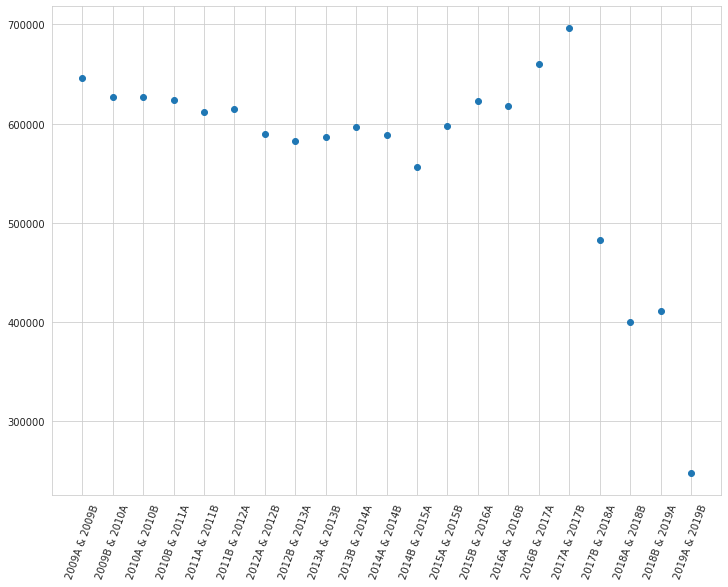

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

fig,ax = plt.subplots()
plt.plot(list(range(len(y))), x, 'o')
ax.set_xticks(list(range(len(y))))
ax.set_xticklabels(y,rotation=70)

#Also plot with real domain union

pass

In [64]:
#TODO increase interval size and see how that changes normal gap size

#See if Alexa's methodology changed singificantly
#Intersection b/w 2010A, 2010B etc. for both Alexa top 100k & top 1M
#Documentation or Google for Alexa changes
#Maybe hone in on more short-term ranks

# Gaps by category

In [65]:
import json

with open ("../data/webshrinker/domains_to_categories.json") as f:
    category_map = json.loads(f.read())

In [66]:
cats = list(category_map.keys())

In [67]:
strip_re = re.compile("(?:https?://)?([^/]*).*?")
def strip_dom(dom):
    try:
        return strip_re.match(dom).group(1)
    except:
        print(dom)
        raise

#Not all domains have categories. Extract the ones that do
categorized_missing_doms = [strip_dom(dom) for dom in missing_doms if strip_dom(dom) in category_map]
categorized_hit_doms = [strip_dom(dom) for dom in all_doms if strip_dom(dom) in category_map]

print(len(categorized_missing_doms),len(missing_doms)-len(categorized_missing_doms))
print(len(categorized_hit_doms),len(all_doms)-len(categorized_hit_doms))

172063 261054
108489 10


In [68]:
categorized_all_doms = categorized_missing_doms + categorized_hit_doms

In [69]:
categories = set()
for cat_list in category_map.values():
    for cat in cat_list:
        categories.add(cat)
categories

{'abortion',
 'adult',
 'advertising',
 'alcoholandtobacco',
 'blogsandpersonal',
 'business',
 'chatandmessaging',
 'contentserver',
 'deceptive',
 'drugs',
 'economyandfinance',
 'education',
 'entertainment',
 'foodandrecipes',
 'gambling',
 'games',
 'hacking',
 'health',
 'humor',
 'illegalcontent',
 'informationtech',
 'jobrelated',
 'malicious',
 'mediasharing',
 'messageboardsandforums',
 'newsandmedia',
 'parked',
 'personals',
 'proxyandfilteravoidance',
 'realestate',
 'religion',
 'searchenginesandportals',
 'shopping',
 'socialnetworking',
 'sports',
 'streamingmedia',
 'translators',
 'travel',
 'uncategorized',
 'vehicles',
 'virtualreality',
 'weapons'}

In [70]:
def plot_category_comparison(ds1,ds2,ds1name,ds2name):
    
    ds1 = [strip_dom(dom) for dom in ds1 if strip_dom(dom) in category_map]
    ds2 = [strip_dom(dom) for dom in ds2 if strip_dom(dom) in category_map]
    
    cat_to_count_ds1 = {cat:0 for cat in categories}
    cat_to_count_ds2 = {cat:0 for cat in categories}

    for dom in ds1:
        for cat in category_map[dom]:
            cat_to_count_ds1[cat] += 1

    for dom in ds2:
        for cat in category_map[dom]:
            cat_to_count_ds2[cat] += 1
    
    
    #plotting
    labels = list(categories)
    x = np.arange(len(labels))
    width=0.35
    
    
    fig, ax = plt.subplots()

    cat_ds1_sum = sum(cat_to_count_ds1.values(),0)
    cat_ds2_sum = sum(cat_to_count_ds2.values(),0)

    ax.bar(x-width/2, [cat_to_count_ds1[l]/cat_ds1_sum for l in labels], label=ds1name,width=width)
    ax.bar(x+width/2, [cat_to_count_ds2[l]/cat_ds2_sum for l in labels], label=ds2name,width=width)

    plt.xticks(x,labels,rotation="vertical")
    plt.title("Number of domains matching each category")
    plt.legend()


    plt.show()
    
    return sorted([((cat_to_count_ds1[l]/cat_ds1_sum) / (cat_to_count_ds2[l]/cat_ds2_sum), l) for l in labels])

In [71]:
def get_top_cats(ds,topX=10):
    cat_to_count = {cat:0 for cat in categories}
    for dom in ds:
        for cat in category_map[dom]:
            cat_to_count[cat] += 1
    pairs = [(count,cat) for cat,count in cat_to_count.items()]
    pairs = sorted(pairs,reverse=True)
    return [cat for count,cat in pairs[:topX]]

get_top_cats(categorized_hit_doms)

['business',
 'education',
 'informationtech',
 'entertainment',
 'shopping',
 'uncategorized',
 'parked',
 'adult',
 'newsandmedia',
 'games']

In [87]:
def plot_category_dist(ds1,ds2,top_cats):
    
    plt.figure(figsize=(7,3))
    
    ds1 = [strip_dom(dom) for dom in ds1 if strip_dom(dom) in category_map]
    ds2 = [strip_dom(dom) for dom in ds2 if strip_dom(dom) in category_map]
    
    
    
    cat_to_count_ds1 = {cat:0 for cat in top_cats}
    cat_to_count_ds1["other"] = 0
    cat_to_count_ds1 = {cat:0 for cat in top_cats}
    cat_to_count_ds2 = {cat:0 for cat in top_cats}
    cat_to_count_ds1["other"] = 0
    cat_to_count_ds2["other"] = 0

    for dom in ds1:
        if dom in category_map:
            cats = category_map[dom]
        else:
            cats = ["uncategorized"]
        for cat in cats:
            if cat not in top_cats:
                cat = "other"
            cat_to_count_ds1[cat] += 1


    for dom in ds2:
        if dom in category_map and len(category_map[dom]) != 0:
            cats = category_map[dom]
        else:
            cats = ["uncategorized"]
        for cat in cats:
            if cat not in top_cats:
                cat = "other"
            cat_to_count_ds2[cat] += 1
    
    
    #plotting
    labels = list(top_cats) + ["other"]
    x = np.arange(len(labels))
    width=0.35
    
    
    order = list(zip(*sorted([(cat_to_count_ds1[l],l) for l in labels], reverse=True)))[1]
    
    chart = sns.barplot(labels,[cat_to_count_ds1[l]+cat_to_count_ds2[l] for l in labels],color="coral",order=order,label="Absent Websites")
    chart = sns.barplot(labels,[cat_to_count_ds1[l] for l in labels],color="steelblue",order=order,label="Present Websites")
    chart.set_xticklabels(chart.get_xticklabels(),rotation=45,ha="right")
    chart.set(ylabel="Number of domains",title="Number of domains with policies in each category")
    
    locs, labels = plt.xticks()            # Get locations and labels
    plt.xticks(np.array(locs) + 0.25, labels)  # Set locations and labels
    
    plt.legend()
    
    plt.savefig("figures/category_dist.pdf",bbox_inches='tight')
    
    #plt.ylim(0,1)
    
#     fig, ax = plt.subplots()

#     ax.bar(labels, [cat_to_count_ds1[l] for l in labels],color="steelblue")

#     plt.xticks(x,labels,rotation=90)
#     plt.title("Number of domains matching each category")

#     plt.show()
    
    #return sorted([((cat_to_count_ds1[l]/cat_ds1_sum) / (cat_to_count_ds2[l]/cat_ds2_sum), l) for l in labels])

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


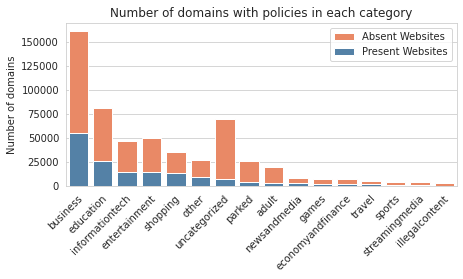

In [88]:
plot_category_dist(all_doms,categorized_all_doms,set(get_top_cats(categorized_all_doms,topX=15)))

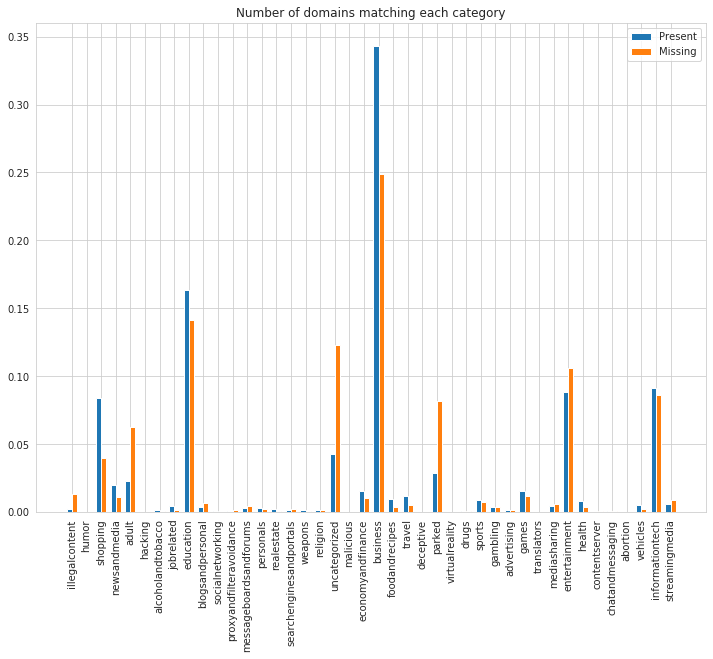

[(0.0, 'abortion'),
 (0.14888674657145937, 'illegalcontent'),
 (0.27110966963673944, 'contentserver'),
 (0.31886194099321064, 'hacking'),
 (0.34446362678814524, 'uncategorized'),
 (0.3530577338157973, 'parked'),
 (0.36451299626237416, 'adult'),
 (0.4058242885368135, 'translators'),
 (0.4181795947451942, 'deceptive'),
 (0.4405160951874074, 'searchenginesandportals'),
 (0.510179105589137, 'malicious'),
 (0.5437282984736834, 'blogsandpersonal'),
 (0.6152490315199395, 'messageboardsandforums'),
 (0.6377238819864212, 'humor'),
 (0.6432512829137141, 'streamingmedia'),
 (0.6688323640345393, 'mediasharing'),
 (0.8069159323093493, 'proxyandfilteravoidance'),
 (0.8365474721343518, 'entertainment'),
 (0.9110341171234589, 'virtualreality'),
 (1.025672576861494, 'religion'),
 (1.0569063818018674, 'informationtech'),
 (1.0628731366440354, 'advertising'),
 (1.074648407545631, 'gambling'),
 (1.1566840393068687, 'education'),
 (1.2512686594425515, 'sports'),
 (1.371187481624748, 'games'),
 (1.379566457

In [89]:
plot_category_comparison(categorized_hit_doms,categorized_missing_doms,"Present","Missing")

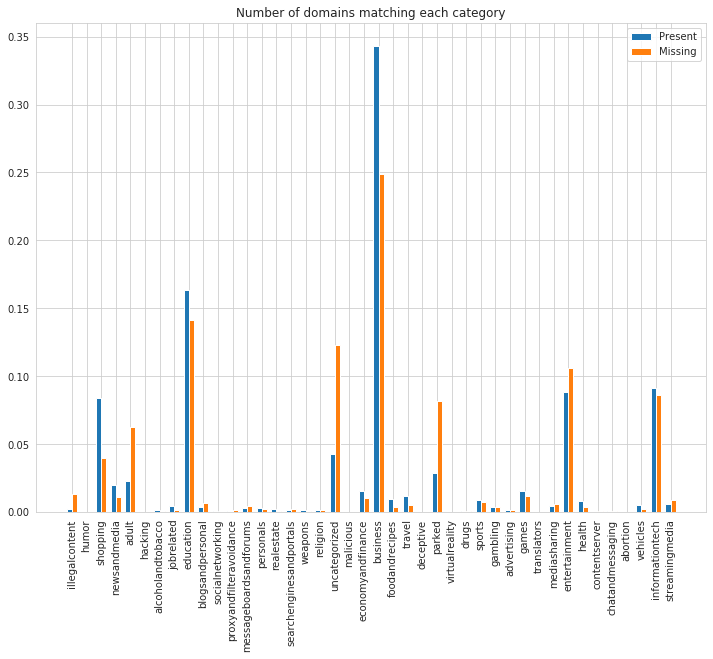

[(0.0, 'abortion'),
 (0.14888674657145937, 'illegalcontent'),
 (0.27110966963673944, 'contentserver'),
 (0.31886194099321064, 'hacking'),
 (0.34446362678814524, 'uncategorized'),
 (0.3530577338157973, 'parked'),
 (0.36451299626237416, 'adult'),
 (0.4058242885368135, 'translators'),
 (0.4181795947451942, 'deceptive'),
 (0.4405160951874074, 'searchenginesandportals'),
 (0.510179105589137, 'malicious'),
 (0.5437282984736834, 'blogsandpersonal'),
 (0.6152490315199395, 'messageboardsandforums'),
 (0.6377238819864212, 'humor'),
 (0.6432512829137141, 'streamingmedia'),
 (0.6688323640345393, 'mediasharing'),
 (0.8069159323093493, 'proxyandfilteravoidance'),
 (0.8365474721343518, 'entertainment'),
 (0.9110341171234589, 'virtualreality'),
 (1.025672576861494, 'religion'),
 (1.0569063818018674, 'informationtech'),
 (1.0628731366440354, 'advertising'),
 (1.074648407545631, 'gambling'),
 (1.1566840393068687, 'education'),
 (1.2512686594425515, 'sports'),
 (1.371187481624748, 'games'),
 (1.379566457

In [90]:
plot_category_comparison(all_doms,missing_doms,"Present","Missing")

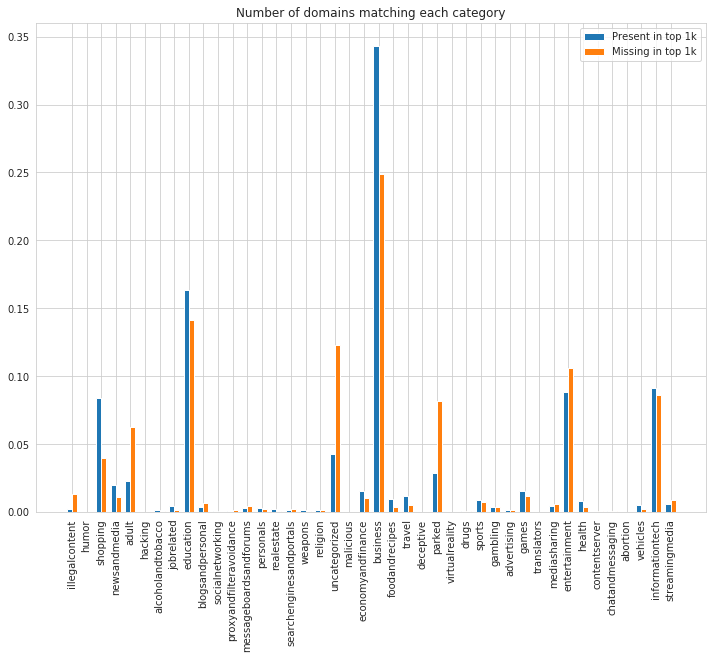

[(0.0, 'abortion'),
 (0.14888674657145937, 'illegalcontent'),
 (0.27110966963673944, 'contentserver'),
 (0.31886194099321064, 'hacking'),
 (0.34446362678814524, 'uncategorized'),
 (0.3530577338157973, 'parked'),
 (0.36451299626237416, 'adult'),
 (0.4058242885368135, 'translators'),
 (0.4181795947451942, 'deceptive'),
 (0.4405160951874074, 'searchenginesandportals'),
 (0.510179105589137, 'malicious'),
 (0.5437282984736834, 'blogsandpersonal'),
 (0.6152490315199395, 'messageboardsandforums'),
 (0.6377238819864212, 'humor'),
 (0.6432512829137141, 'streamingmedia'),
 (0.6688323640345393, 'mediasharing'),
 (0.8069159323093493, 'proxyandfilteravoidance'),
 (0.8365474721343518, 'entertainment'),
 (0.9110341171234589, 'virtualreality'),
 (1.025672576861494, 'religion'),
 (1.0569063818018674, 'informationtech'),
 (1.0628731366440354, 'advertising'),
 (1.074648407545631, 'gambling'),
 (1.1566840393068687, 'education'),
 (1.2512686594425515, 'sports'),
 (1.371187481624748, 'games'),
 (1.379566457

In [91]:
doms_1k = set()
#Iter years
for season_dict in alexa.alexa_rankings.values():
    #iter seasons
    for dom_dict in season_dict.values():
        #iter domains
        for dom, ranking in dom_dict.items():
            if ranking <= 1000:
                possible_doms.add("http://%s" % dom)
                
present_doms_1k = list(set(all_doms) & doms_1k)
missing_doms_1k = list(set(missing_doms) & doms_1k)
plot_category_comparison(all_doms,missing_doms,"Present in top 1k","Missing in top 1k")

In [92]:
alexa_ranks_2009B = sorted([(rank,dom) for dom,rank in alexa.alexa_rankings[2009]["B"].items()])
alexa_ranks_2009B = [dom for rank,dom in alexa_ranks_2009B]

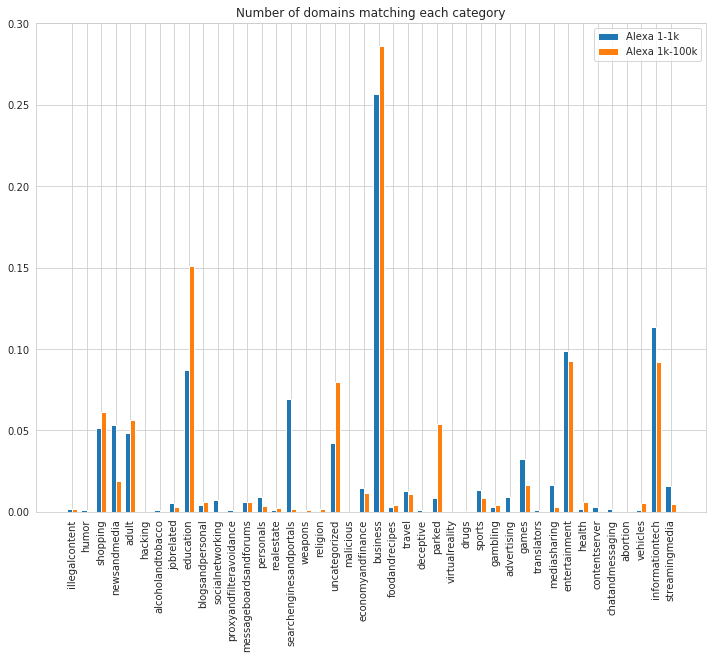

[(0.0, 'abortion'),
 (0.0, 'drugs'),
 (0.0, 'hacking'),
 (0.0, 'malicious'),
 (0.0, 'religion'),
 (0.0, 'virtualreality'),
 (0.0, 'weapons'),
 (0.15602851147641245, 'parked'),
 (0.1890171381777769, 'vehicles'),
 (0.34086354206954744, 'health'),
 (0.4156448293603155, 'realestate'),
 (0.5249968522933581, 'uncategorized'),
 (0.5778251652737663, 'education'),
 (0.693330949401037, 'blogsandpersonal'),
 (0.6962939021762551, 'gambling'),
 (0.7661415663444061, 'foodandrecipes'),
 (0.8384484228473998, 'shopping'),
 (0.8567566944473263, 'adult'),
 (0.8961229068311121, 'business'),
 (1.020455781477518, 'messageboardsandforums'),
 (1.0678901598290969, 'entertainment'),
 (1.1460687440275057, 'travel'),
 (1.180672268907563, 'illegalcontent'),
 (1.2343391902215433, 'informationtech'),
 (1.2630447527848347, 'economyandfinance'),
 (1.58494915475918, 'jobrelated'),
 (1.6095182753952644, 'sports'),
 (1.629327731092437, 'alcoholandtobacco'),
 (1.953177094503695, 'games'),
 (1.986985037917606, 'proxyandfil

In [93]:
plot_category_comparison(alexa_ranks_2009B[:1000],alexa_ranks_2009B[1000:100000],"Alexa 1-1k","Alexa 1k-100k")

In [25]:
illegal_doms = []
for dom in category_map:
    if "illegalcontent" in category_map[dom]:
        illegal_doms.append(dom)

In [28]:
print('\n'.join(map(lambda s: "http://%s" % s,random.sample(illegal_doms,100))))

http://2ddl.vg
http://7starhd.com
http://freecrackpatch.com
http://savef.net
http://atomload.to
http://bdmusic24.net
http://putlockerfree.com
http://filmonde.com
http://todayfull.com
http://topkickass.net
http://torrentz-2.eu
http://downloadhub.biz
http://hdbits.org
http://indomovie.fun
http://baixarfilmesgratis.net
http://movies5x.com
http://world4free.ind.in
http://ytshdmovies.com
http://movies500.org
http://odownloadx.com
http://torrentz2in.top
http://mnitro.com
http://attmovie.info
http://cmovieshd.se
http://wanz.jp
http://tamilmv.cam
http://fmtorrent.com
http://limetorrents.zone
http://filmcomplet.stream
http://extratorrents.ch
http://123movierulz.live
http://bdmusic90.com
http://9baranfilm.com
http://moviescounter.co
http://marinarockers.com
http://eztv.yt
http://downloadhub.online
http://isaitamil.net
http://moviezwaphd.la
http://thepiratebay.tel
http://megashare.bz
http://downloadall.in
http://onlinemoviesgold.com
http://torrentsbay.net
http://tamilyogi.tv
http://odia1.me
http:

In [96]:
illegal_doms = []
for dom in all_doms:
    dom = strip_dom(dom)
    if dom in category_map and "illegalcontent" in category_map[dom]:
        illegal_doms.append(dom)

In [1]:
print("\n".join(illegal_doms[:100]))

NameError: name 'illegal_doms' is not defined

In [98]:
def plot_category_disparity(ds1,ds2,ds1name,ds2name,top_cats=None):    
    ds1 = [strip_dom(dom) for dom in ds1 if strip_dom(dom) in category_map]
    ds2 = [strip_dom(dom) for dom in ds2 if strip_dom(dom) in category_map]
    
    if top_cats:
        cat_to_count_ds1 = {cat:0 for cat in top_cats}
        cat_to_count_ds2 = {cat:0 for cat in top_cats}
        cat_to_count_ds1["other"] = 0
        cat_to_count_ds2["other"] = 0
    else:    
        cat_to_count_ds1 = {cat:0 for cat in categories}
        cat_to_count_ds2 = {cat:0 for cat in categories}


    for dom in ds1:
        if dom in category_map:
            cats = category_map[dom]
        else:
            cats = ["uncategorized"]
        for cat in cats:
            if cat not in top_cats:
                cat = "other"
            cat_to_count_ds1[cat] += 1


    for dom in ds2:
        if dom in category_map and len(category_map[dom]) != 0:
            cats = category_map[dom]
        else:
            cats = ["uncategorized"]
        for cat in cats:
            if cat not in top_cats:
                cat = "other"
            cat_to_count_ds2[cat] += 1
    
    
    #plotting
    labels = list(top_cats) + ["other"] if top_cats else list(categories) 
    x = np.arange(len(labels))
    width=0.35
    
    
    fig, ax = plt.subplots()

    cat_ds1_sum = sum(cat_to_count_ds1.values(),0)
    cat_ds2_sum = sum(cat_to_count_ds2.values(),0)
    
    
    order = list(zip(*sorted([(cat_to_count_ds1[l]/(cat_to_count_ds1[l]+cat_to_count_ds2[l]),l) for l in labels], reverse=True)))[1]
    
    chart = sns.barplot(labels,[cat_to_count_ds1[l]/(cat_to_count_ds1[l]+cat_to_count_ds2[l]) for l in labels],color="steelblue",order=order)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
    chart.set(ylabel="Proportion of domains present",title="Proportion of domains in each category that are present in the dataset")
    plt.ylim(0,1)

    plt.savefig("figures/category_missing_perc.pdf",bbox_inches='tight')
    
    #ax.bar(x, [cat_to_count_ds1[l]/(cat_to_count_ds1[l]+cat_to_count_ds2[l]) for l in labels], label=ds1name,width=width,color="steelblue")
    #ax.bar(x, [cat_to_count_ds2[l]/(cat_to_count_ds1[l]+cat_to_count_ds2[l]) for l in labels], bottom=[cat_to_count_ds1[l]/(cat_to_count_ds1[l]+cat_to_count_ds2[l]) for l in labels], label=ds2name,width=width,color="coral")

    #plt.xticks(x,labels,rotation="vertical")
    #plt.title("Proportion of each category that is present vs absent")
    #plt.legend()


    #plt.show()

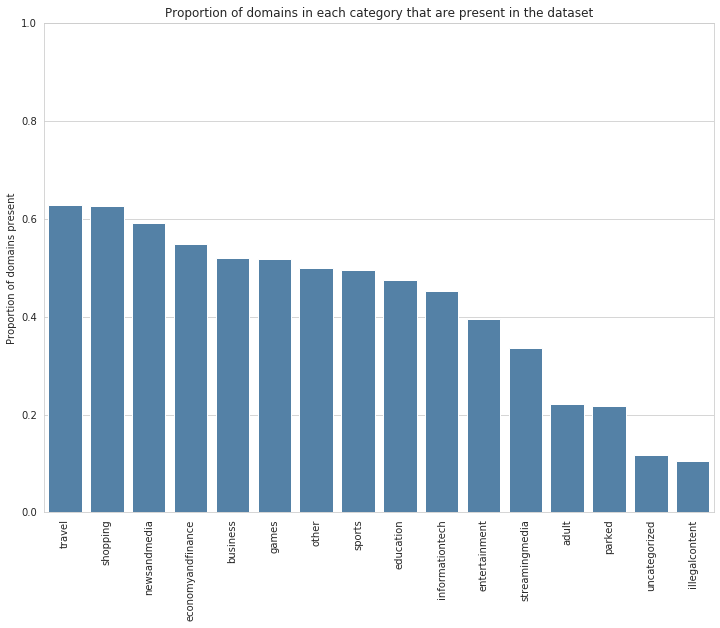

In [99]:
plot_category_disparity(categorized_hit_doms,categorized_missing_doms,"Present","Absent",top_cats=set(get_top_cats(categorized_all_doms,topX=15)))

In [100]:
len(set(all_doms) - set(categorized_hit_doms))

108499

In [101]:
len(all_doms)

108499

In [102]:
all_doms[0]

'http://krebsonsecurity.com'

In [103]:
categorized_hit_doms[0]

'krebsonsecurity.com'

In [104]:
sum([1 if len(category_map[dom]) == 0 else 0 for dom in categorized_all_doms])

31193

In [105]:
len(category_map)

280552

In [106]:
len(possible_doms)

541616

In [28]:
with open("../data/domains-nopolicy.txt") as f:
    english_doms = set(f.read().strip().split('\n'))
english_absent_doms = list(english_doms - set(categorized_hit_doms))

NameError: name 'categorized_hit_doms' is not defined

In [17]:
len(english_absent_doms), len(english_absent_doms) / len(english_doms) * 100

(280798, 100.0)

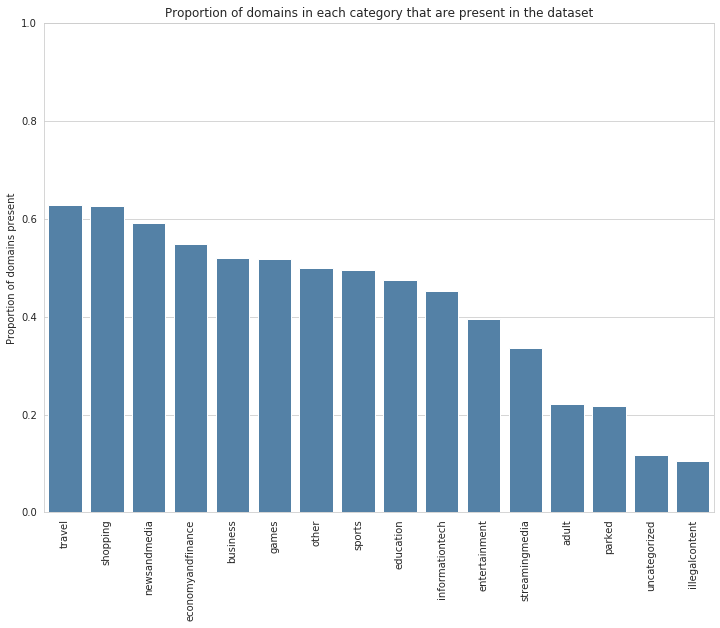

In [109]:
plot_category_disparity(categorized_hit_doms,english_absent_doms,"Present","Absent",top_cats=set(get_top_cats(categorized_all_doms,topX=15)))

In [110]:
len(categories)-15

27